<a href="https://colab.research.google.com/github/ussenuk/Gender-Recognition-using-CNN-from-Scratch/blob/master/genderRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gender Recognition using Convolutional Neural Networks

By KIMANUKA ABRE USSEN (196103008)

We used CNN for predicting gender among 30 speakers (15 males and 15 females), we designed the CNN from scratch without using any tensorflow or keras library and got 93.47%  accuracy when classifying the gender of speakers that the model had never hear before.

The problem was to learn how to manipulate audio data and build model to classify sounds.

We did a lot of research to understand how to solve the problem and how a lot of people have tackled the problem.

In this approach we converted the audio clips to pictures(mel spectrogram) and used those images to train a convolutional neural network model (CNN).

let's import the required libriries

In [0]:
import pandas as pd
import numpy as np
from numpy import argmax
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
import IPython.display
import random
import warnings
import os
from PIL import Image
import pathlib
import csv
# sklearn Preprocessing
from sklearn.model_selection import train_test_split

I will try building a CNN from scratch for 2-class classification for a gender dataset created by my own from Librispeech corpus. In my dataset, we have a total of 3000 audio clips which are divided into two folders -male (having 1500 audio clips from 15 males speapers) and female (having 1500 audio clips from 15 female speakers).

Now convert the audio data files into JPG format images or basically extracting the Mel Spectrogram for every Audio. We will use librosa python library to extract Mel Spectrogram for every audio file.

Using a function to generate and save the melspectrogram for each audio file

In [0]:
#Now convert the audio data files into JPG format images or basically extracting 
#the Mel Spectrogram for every Audio. We will use librosa python library to extract 
#Mel Spectrogram for every audio file.
#Using a function to generate and save the melspectrogram for each audio file

plt.figure(figsize=(1,1))
gender = 'male female'.split()
for g in gender:
    pathlib.Path(f'./img_data/{g}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'./drive/My Drive/gender_30/{g}'):
        songname = f'./drive/My Drive/gender_30/{g}/{filename}'
        # Loading the image with no sample rate to use the original sample rate and
        # kaiser_fast to make the speed faster according to a blog post about it (on references)
        X, sample_rate = librosa.load(songname, sr=None, res_type='kaiser_fast')

        # Setting the size of the image
        fig = plt.figure(figsize=[1,1])

        # This is to get rid of the axes and only get the picture 
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        # This is the melspectrogram from the decibels with a linear relationship
        # Setting min and max frequency to account for human voice frequency
        S = librosa.feature.melspectrogram(y=X, sr=sample_rate)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max), x_axis='time', y_axis='mel', fmin=50, fmax=280);

        plt.axis('off');
        plt.savefig(f'./img_data/{g}/{filename[:-4].replace(".", "")}.jpg', dpi=500, bbox_inches='tight',pad_inches=0)
        plt.clf()
#The above code will create a directory img_data containing all the images categorized in the genre.

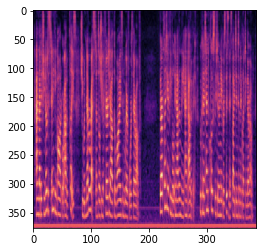

In [89]:
#Let's visualize a generated mel spectrogram image!
import matplotlib.pyplot as plt
import matplotlib.image as img 

img1 = img.imread('/content/img_data/female/103-1240-0000.jpg')
plt.figure(1)
plt.imshow(img1)
plt.show()


The created images (mel spectrograms) are in color RGB, and since we are using only numpy to build our model, we should make the problem as simple as possible by converting the color RGB image (3 channels) to a grayscale image (1 channel). this will clearly simplify the building of our CNN model later on. 

In [0]:
# Transform the images into grayscale

import matplotlib.image as img 
from PIL import Image  
import numpy as np  

gender = 'male female'.split()
for g in gender:
    pathlib.Path(f'./img_data1/{g}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'./img_data/{g}'):  
        img = Image.open(f'./img_data/{g}/{filename}') 
        img1 = img.convert('L')  #convert a gray scale
        img1.save(f'./img_data1/{g}/{filename}')

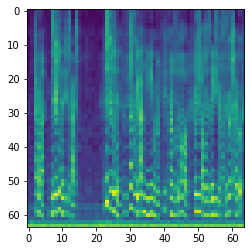

In [93]:
#Let's visualize a generated mel spectrogram image!
import matplotlib.pyplot as plt
import matplotlib.image as img 

img1 = img.imread('/content/img_data1/female/103-1240-0000.jpg')
plt.figure(1)
plt.imshow(img1)
plt.show()

CNN accept a particular input data with small dimension, the generated mel spectrograms have a dimension of 432x288. This is very big as a CNN input data. let resize our full dataset to a dimesion of 64x64.

In [0]:
# Resize the image to an appropriate dimension
from PIL import Image
import os
def resize_aspect_fit():
  for g in gender:
    for filename in os.listdir(f'./img_data1/{g}'):
        image = f'./img_data1/{g}/{filename}'
        image = Image.open(f'./img_data1/{g}/{filename}')
        new_image_height = int(64)
        new_image_length = int(64)
        image = image.resize((new_image_height, new_image_length), Image.ANTIALIAS)
        image.save(f'./img_data1/{g}/{filename}' , 'JPEG', quality=90)
resize_aspect_fit()

Our next step is to split the data into the train set and test set. We will split data by 80% in training and 20% in the test set. The code returns 2 directories for train and test set inside a parent directory.

In [48]:
#Our next step is to split the data into the train set and test set.
#Install split_folders.
!pip install split_folders

In [49]:
# We will split data by 80% in training and 20% in the test set.
import split_folders
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
split_folders.ratio('./img_data1/', output="./data", seed=1337, ratio=(.8, .2)) # default values

#The above code returns 2 directories for train and test set inside a parent directory.

Copying files: 3064 files [00:01, 1870.94 files/s]


First, we are going to load the file names and their respective target labels into numpy array! 

In [0]:
# First, we are going to load the file names and their respective target labels into numpy array! 
from sklearn.datasets import load_files
import numpy as np

train_dir = './data/train'
test_dir = './data/test'

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels

In [51]:
# Before runing this script change name of folder under data from val to test    
x_train, y_train,target_labels = load_dataset(train_dir)
x_test, y_test,_ = load_dataset(test_dir)
print('Loading complete!')

print('Training set size : ' , x_train.shape[0])
print('Testing set size : ', x_test.shape[0])

Loading complete!
Training set size :  2451
Testing set size :  613


Let's confirm the number of classes :p

In [52]:
# Let's confirm the number of classes :p
no_of_classes = len(np.unique(y_train))
no_of_classes

2

In [53]:
print(y_train[0:100])
# target labels are numbers corresponding to class label. I dont think We need to change them to a vector of 2 elements.

[0 1 0 0 0 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 1 1 0 0 0 1
 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 1 0 0 1 1
 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1]


In [54]:
x_train[0]
# training data is just file names of images. We need to convert them into pixel matrix.

'./data1/train/female/125-121124-0088.jpg'

We just have the file names in the x set. Let's load the images and convert them into array.

In [0]:
# We just have the file names in the x set. Let's load the images and convert them into array.
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from PIL import Image
def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        #Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file,color_mode = "grayscale")))
    return images_as_array

In [56]:
x_train = np.array(convert_image_to_array(x_train))
print('Training set shape : ',x_train.shape)

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

print('1st training image shape ',x_train[0].shape)

Training set shape :  (2451, 64, 64, 1)
Test set shape :  (613, 64, 64, 1)
1st training image shape  (64, 64, 1)


In [57]:
print('1st training image as array',x_train[0]) # don't worry if you see only 255s..
# there are elements will other values too :p

1st training image as array [[[  9.]
  [  4.]
  [  1.]
  ...
  [  8.]
  [  0.]
  [ 21.]]

 [[ 14.]
  [  5.]
  [  0.]
  ...
  [  5.]
  [  8.]
  [ 18.]]

 [[ 30.]
  [ 15.]
  [  0.]
  ...
  [  3.]
  [ 15.]
  [ 24.]]

 ...

 [[ 71.]
  [ 70.]
  [ 59.]
  ...
  [ 79.]
  [ 62.]
  [ 61.]]

 [[ 78.]
  [ 59.]
  [ 59.]
  ...
  [ 78.]
  [ 60.]
  [ 69.]]

 [[100.]
  [106.]
  [107.]
  ...
  [105.]
  [105.]
  [ 99.]]]


Reshape the numpy array of your data to a shape of (number of content, width, height) by removing the channel (1) out of the dimension so that we can have a data structure similar to the one of our CNN model 

In [0]:
#Reshape the numpy array of your data to a shape of (number of content, width, height)

x_train= x_train.reshape((2451,64, 64))

In [0]:
x_test= x_test.reshape((613,64, 64))

In [61]:
x_train.shape

(2451, 64, 64)

#CNN modelling

Note: In this implementation, we assume the input is a 2d numpy array for simplicity, because that's
how our  images are stored. This works for us because we use it as the first layer in our
network, but most CNNs have many more Conv layers. If we were building a bigger network that needed
to use Conv3x3 multiple times, we'd have to make the input be a 3d numpy array.

In [0]:
import numpy as np

class Conv3x3:
  # A Convolution layer using 3x3 filters.

  def __init__(self, num_filters):
    self.num_filters = num_filters

    # filters is a 3d array with dimensions (num_filters, 3, 3)
    # We divide by 9 to reduce the variance of our initial values
    self.filters = np.random.randn(num_filters, 3, 3) / 9

  def iterate_regions(self, image):
    '''
    Generates all possible 3x3 image regions using valid padding.
    - image is a 2d numpy array.
    '''
    h, w = image.shape

    for i in range(h - 2):
      for j in range(w - 2):
        im_region = image[i:(i + 3), j:(j + 3)]
        yield im_region, i, j

  def forward(self, input):
    '''
    Performs a forward pass of the conv layer using the given input.
    Returns a 3d numpy array with dimensions (h, w, num_filters).
    - input is a 2d numpy array
    '''
    self.last_input = input

    h, w = input.shape
    output = np.zeros((h - 2, w - 2, self.num_filters))

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.sum(im_region * self.filters, axis=(1, 2))

    return output

  def backprop(self, d_L_d_out, learn_rate):
    '''
    Performs a backward pass of the conv layer.
    - d_L_d_out is the loss gradient for this layer's outputs.
    - learn_rate is a float.
    '''
    d_L_d_filters = np.zeros(self.filters.shape)

    for im_region, i, j in self.iterate_regions(self.last_input):
      for f in range(self.num_filters):
        d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region

    # Update filters
    self.filters -= learn_rate * d_L_d_filters

    # We aren't returning anything here since we use Conv3x3 as the first layer in our CNN.
    # Otherwise, we'd need to return the loss gradient for this layer's inputs, just like every
    # other layer in our CNN.
    return None

In [0]:
class MaxPool2:
  # A Max Pooling layer using a pool size of 2.

  def iterate_regions(self, image):
    '''
    Generates non-overlapping 2x2 image regions to pool over.
    - image is a 2d numpy array
    '''
    h, w, _ = image.shape
    new_h = h // 2
    new_w = w // 2

    for i in range(new_h):
      for j in range(new_w):
        im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
        yield im_region, i, j

  def forward(self, input):
    '''
    Performs a forward pass of the maxpool layer using the given input.
    Returns a 3d numpy array with dimensions (h / 2, w / 2, num_filters).
    - input is a 3d numpy array with dimensions (h, w, num_filters)
    '''
    self.last_input = input

    h, w, num_filters = input.shape
    output = np.zeros((h // 2, w // 2, num_filters))

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.amax(im_region, axis=(0, 1))

    return output

  def backprop(self, d_L_d_out):
    '''
    Performs a backward pass of the maxpool layer.
    Returns the loss gradient for this layer's inputs.
    - d_L_d_out is the loss gradient for this layer's outputs.
    '''
    d_L_d_input = np.zeros(self.last_input.shape)

    for im_region, i, j in self.iterate_regions(self.last_input):
      h, w, f = im_region.shape
      amax = np.amax(im_region, axis=(0, 1))

      for i2 in range(h):
        for j2 in range(w):
          for f2 in range(f):
            # If this pixel was the max value, copy the gradient to it.
            if im_region[i2, j2, f2] == amax[f2]:
              d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]

    return d_L_d_input

In [0]:
class Softmax:
  # A standard fully-connected layer with softmax activation.

  def __init__(self, input_len, nodes):
    # We divide by input_len to reduce the variance of our initial values
    self.weights = np.random.randn(input_len, nodes) / input_len
    self.biases = np.zeros(nodes)

  def forward(self, input):
    '''
    Performs a forward pass of the softmax layer using the given input.
    Returns a 1d numpy array containing the respective probability values.
    - input can be any array with any dimensions.
    '''
    self.last_input_shape = input.shape

    input = input.flatten()
    self.last_input = input

    input_len, nodes = self.weights.shape

    totals = np.dot(input, self.weights) + self.biases
    self.last_totals = totals

    exp = np.exp(totals)
    return exp / np.sum(exp, axis=0)

  def backprop(self, d_L_d_out, learn_rate):
    '''
    Performs a backward pass of the softmax layer.
    Returns the loss gradient for this layer's inputs.
    - d_L_d_out is the loss gradient for this layer's outputs.
    - learn_rate is a float.
    '''
    # We know only 1 element of d_L_d_out will be nonzero
    for i, gradient in enumerate(d_L_d_out):
      if gradient == 0:
        continue

      # e^totals
      t_exp = np.exp(self.last_totals)

      # Sum of all e^totals
      S = np.sum(t_exp)

      # Gradients of out[i] against totals
      d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
      d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

      # Gradients of totals against weights/biases/input
      d_t_d_w = self.last_input
      d_t_d_b = 1
      d_t_d_inputs = self.weights

      # Gradients of loss against totals
      d_L_d_t = gradient * d_out_d_t

      # Gradients of loss against weights/biases/input
      d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
      d_L_d_b = d_L_d_t * d_t_d_b
      d_L_d_inputs = d_t_d_inputs @ d_L_d_t

      # Update weights / biases
      self.weights -= learn_rate * d_L_d_w
      self.biases -= learn_rate * d_L_d_b

      return d_L_d_inputs.reshape(self.last_input_shape)

In [66]:

train_images = x_train[:2451]
train_labels = y_train[:2451]
test_images = x_test[:613]
test_labels = y_test[:613]


conv = Conv3x3(8)                  # 64x64x1 -> 62x62x8
pool = MaxPool2()                  # 62x62x8 -> 31x31x8
softmax = Softmax(31 * 31 * 8, 2) # 31x31x8 -> 2

def forward(image, label):
  '''
  Completes a forward pass of the CNN and calculates the accuracy and
  cross-entropy loss.
  - image is a 2d numpy array
  - label is a digit
  '''
  # We transform the image from [0, 255] to [-0.5, 0.5] to make it easier
  # to work with. This is standard practice.
  out = conv.forward((image / 255) - 0.5)
  out = pool.forward(out)
  out = softmax.forward(out)

  # Calculate cross-entropy loss and accuracy. np.log() is the natural log.
  loss = -np.log(out[label])
  acc = 1 if np.argmax(out) == label else 0

  return out, loss, acc

def train(im, label, lr=.005):
  '''
  Completes a full training step on the given image and label.
  Returns the cross-entropy loss and accuracy.
  - image is a 2d numpy array
  - label is a digit
  - lr is the learning rate
  '''
  # Forward
  out, loss, acc = forward(im, label)

  # Calculate initial gradient
  gradient = np.zeros(2)
  gradient[label] = -1 / out[label]

  # Backprop
  gradient = softmax.backprop(gradient, lr)
  gradient = pool.backprop(gradient)
  gradient = conv.backprop(gradient, lr)

  return loss, acc

print('Gender Recognition CNN initialized!')

# Train the CNN for 3 epochs
for epoch in range(3):
  print('--- Epoch %d ---' % (epoch + 1))

  # Shuffle the training data
  permutation = np.random.permutation(len(train_images))
  train_images = train_images[permutation]
  train_labels = train_labels[permutation]

  # Train!
  loss = 0
  num_correct = 0
  for i, (im, label) in enumerate(zip(train_images, train_labels)):
    if i % 100 == 99:
      print(
        '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
        (i + 1, loss / 100, num_correct)
      )
      loss = 0
      num_correct = 0

    l, acc = train(im, label)
    loss += l
    num_correct += acc

# Test the CNN
print('\n--- Testing the CNN ---')
loss = 0
num_correct = 0
for im, label in zip(test_images, test_labels):
  _, l, acc = forward(im, label)
  loss += l
  num_correct += acc

num_tests = len(test_images)
print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)

Gender Recognition CNN initialized!
--- Epoch 1 ---
[Step 100] Past 100 steps: Average Loss 0.703 | Accuracy: 52%
[Step 200] Past 100 steps: Average Loss 0.688 | Accuracy: 57%
[Step 300] Past 100 steps: Average Loss 0.659 | Accuracy: 65%
[Step 400] Past 100 steps: Average Loss 0.628 | Accuracy: 67%
[Step 500] Past 100 steps: Average Loss 0.599 | Accuracy: 71%
[Step 600] Past 100 steps: Average Loss 0.577 | Accuracy: 75%
[Step 700] Past 100 steps: Average Loss 0.520 | Accuracy: 82%
[Step 800] Past 100 steps: Average Loss 0.499 | Accuracy: 76%
[Step 900] Past 100 steps: Average Loss 0.438 | Accuracy: 80%
[Step 1000] Past 100 steps: Average Loss 0.458 | Accuracy: 81%
[Step 1100] Past 100 steps: Average Loss 0.401 | Accuracy: 83%
[Step 1200] Past 100 steps: Average Loss 0.386 | Accuracy: 87%
[Step 1300] Past 100 steps: Average Loss 0.367 | Accuracy: 84%
[Step 1400] Past 100 steps: Average Loss 0.454 | Accuracy: 80%
[Step 1500] Past 100 steps: Average Loss 0.342 | Accuracy: 88%
[Step 1600] 